Let's dive back into the process of making polygons from Doug's processed photos. Flower photos were broken into their various petals of interest, and color differences were maximized by categorizing all pixels into three color poles using kmeans clustering. A "bottom" petal, for instance looks like this, after Doug's pipeline (converted to grayscale):

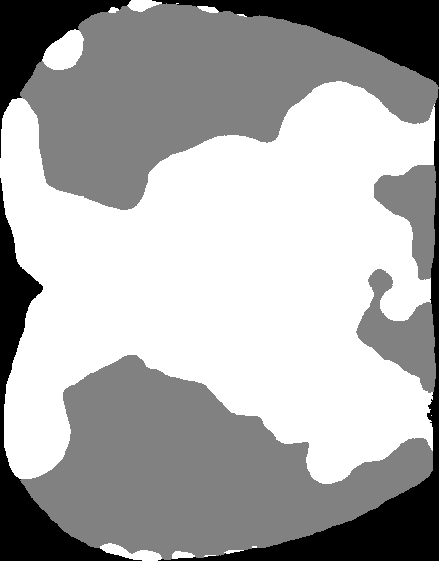

In [1]:
load("../dougRaster/Rotated_and_Cropped/P431F1.mat")
pkg load image
aa = mat2gray(Petals.Clusters.right);
imshow(aa) %% that works.

We want to make polygons of spots and their petals. We can begin by "peeling" these two apart into separate, solid-black images:

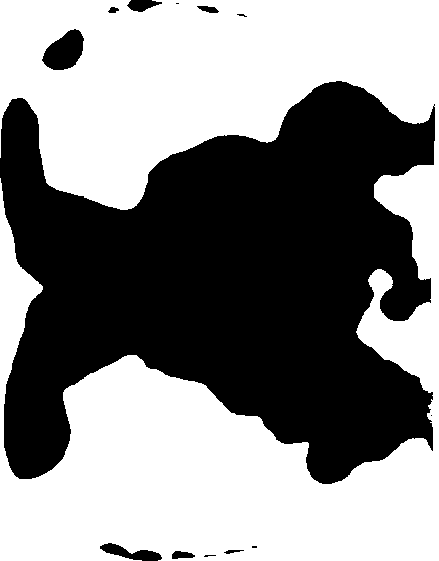

In [2]:
bb = aa < 1;
imshow(bb);


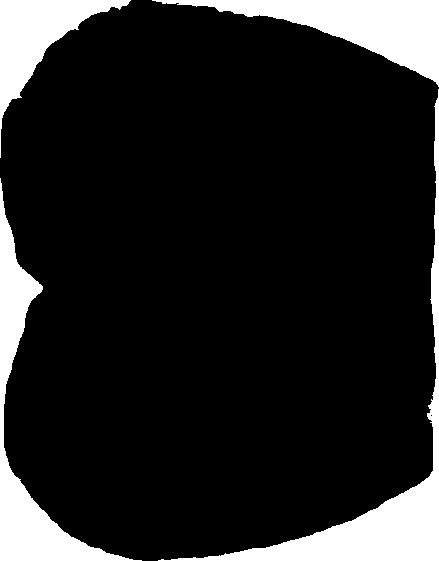

In [4]:
cc = aa == 0;
imshow(cc);

We save these and export them for gimp...